In [13]:
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ttest_ind
import researchpy
import seaborn as sns
import sys
pd.set_option('display.width', None)


In [14]:
print(f"Seaborn version: {sns.__version__}")


Seaborn version: 0.13.2


In [15]:
import numpy as np
from scipy.interpolate import interp1d

def calculateSD(data):
    standardD = np.std(data, ddof=1)
    return standardD


def calculateSE(data):
    standardError = np.std(data, ddof=1) / np.sqrt(len(data) - 1)
    return standardError


def calculateGridDis(grid1, grid2):
    gridDis = np.linalg.norm(np.array(grid1) - np.array(grid2), ord=1)
    return gridDis


def calculateFirstIntention(goalList):
    for goal in goalList:
        if goal != 0:
            firstGoal = goal
            break
        else:
            firstGoal = None
    return firstGoal


def calculateFirstIntentionConsistency(goalList):
    firstGoal = calculateFirstIntention(goalList)
    finalGoal = calculateFirstIntention(list(reversed(goalList)))
    firstIntention = 1 if firstGoal == finalGoal else 0
    return firstIntention


def arrMean(df, colnames):
    arr = np.array(df[colnames].tolist())
    return np.mean(arr, axis=0)


class GoalInfernce:
    def __init__(self, initPrior, goalPolicy):
        self.initPrior = initPrior
        self.goalPolicy = goalPolicy

    def __call__(self, trajectory, aimAction, target1, target2):
        trajectory = list(map(tuple, trajectory))
        aimAction = list(map(tuple, aimAction))
        priorA = self.initPrior[0]
        goalPosteriorList = [[priorA, 1 - priorA]]
        for playerGrid, action in zip(trajectory, aimAction):
            likelihoodA = self.goalPolicy(playerGrid, target1).get(action, 0.001)
            likelihoodB = self.goalPolicy(playerGrid, target2).get(action, 0.001)

            posteriorA = priorA * likelihoodA / (priorA * likelihoodA + (1 - priorA) * likelihoodB)
            goalPosteriorList.append([posteriorA, 1 - posteriorA])
            priorA = posteriorA
        return goalPosteriorList


def calculateSoftmaxProbability(acionValues, beta):
    exponents = np.multiply(beta, acionValues)
    exponents = np.array([min(700, exponent) for exponent in exponents])
    newProbabilityList = list(np.divide(np.exp(exponents), np.sum(np.exp(exponents))))
    return newProbabilityList


class SoftmaxPolicy:
    def __init__(self, QDict, softmaxBeta):
        self.QDict = QDict
        self.softmaxBeta = softmaxBeta

    def __call__(self, playerGrid, targetGrid):
        actionDict = self.QDict[(playerGrid, targetGrid)]
        actionValues = list(actionDict.values())
        softmaxProbabilityList = calculateSoftmaxProbability(actionValues, self.softmaxBeta)
        softMaxActionDict = dict(zip(actionDict.keys(), softmaxProbabilityList))
        return softMaxActionDict


def calPosteriorByChosenSteps(goalPosteriorList, xnew):
    goalPosterior = np.array(goalPosteriorList)[xnew]
    return goalPosterior


def calPosteriorByInterpolation(goalPosteriorList, xInterpolation):
    x = np.divide(np.arange(len(goalPosteriorList) + 1), len(goalPosteriorList))
    goalPosteriorList.append(1)
    y = np.array(goalPosteriorList)
    f = interp1d(x, y, kind='nearest')
    goalPosterior = f(xInterpolation)
    return goalPosterior


def calGoalPosteriorFromAll(posteriors, trajectory, target1, target2):
    trajectory = list(map(tuple, trajectory))
    goalIndex = None
    if trajectory[-1] == target1:
        goalIndex = 0
    elif trajectory[-1] == target2:
        goalIndex = 1
    else:
        print("trajectory no goal reach! ")
        print(trajectory, target1, target2)
    goalPosteriorList = [posterior[goalIndex] for posterior in posteriors]
    return goalPosteriorList

def calCloserGoal(playerGrid, target1, target2):
    disToTarget1 = calculateGridDis(playerGrid,target1)
    disToTarget2 = calculateGridDis(playerGrid,target2)
    if disToTarget1 < disToTarget2:
        goal = 1
    elif disToTarget1 > disToTarget2:
        goal = 2
    else:
        goal = 0
    return goal


def isNoiseToOther(trajectory, goalList, noisePoint, target1, target2):
    if noisePoint:
        noisePoint = sorted(noisePoint)
        for noiseStep in noisePoint:
            if sum(goalList[:noiseStep])!= 0:
                currentGoal = calculateFirstIntention(list(reversed(goalList[:noiseStep])))
                playerNextGrid = trajectory[noiseStep]
                nextCloserGoal = calCloserGoal(playerNextGrid, target1, target2)
                if currentGoal != 0 and nextCloserGoal != 0 and currentGoal != nextCloserGoal:
                    return True
    return False

def isNoiseToMiddle(trajectory, goalList, noisePoint, target1, target2):
    if noisePoint:
        for noiseStep in noisePoint:
            if sum(goalList[:noiseStep]) != 0:
                currentGoal = calculateFirstIntention(list(reversed(goalList[:noiseStep])))
                playerNextGrid = trajectory[noiseStep]
                nextCloserGoal = calCloserGoal(playerNextGrid, target1, target2)
                if currentGoal != 0 and nextCloserGoal == 0:
                    return True
    return False


def calculateFirstIntentionStep(goalList):
    goal1Step = goal2Step = len(goalList)
    if 1 in goalList:
        goal1Step = goalList.index(1) + 1
    if 2 in goalList:
        goal2Step = goalList.index(2) + 1
    firstIntentionStep = min(goal1Step, goal2Step)
    return firstIntentionStep


def calculateFirstIntentionRatio(goalList):
    firstIntentionStep = calculateFirstIntentionStep(goalList)
    firstIntentionRatio = firstIntentionStep / len(goalList)
    return firstIntentionRatio

def calculateFirstIntention(goalList):
    for goal in goalList:
        if goal != 0:
            firstGoal = goal
            break
        else:
            firstGoal = None
    return firstGoal

def calculateFirstIntentionConsistency(goalList):
    firstGoal = calculateFirstIntention(goalList)
    finalGoal = calculateFirstIntention(list(reversed(goalList)))
    firstIntention = 1 if firstGoal == finalGoal else 0
    return firstIntention

def isReachDiffGoal(goalPlayer1List, goalPlayer2List):
    goalPlayer1 = calculateFirstIntention(goalPlayer1List[::-1])
    goalPlayer2 = calculateFirstIntention(goalPlayer2List[::-1])
    if goalPlayer1 != goalPlayer2:
        return True
    else:
        return False

def calculateFirstIntentionStep(goalList):
    goal1Step = goal2Step = len(goalList)
    if 1 in goalList:
        goal1Step = goalList.index(1) + 1
    if 2 in goalList:
        goal2Step = goalList.index(2) + 1
    firstIntentionStep = min(goal1Step, goal2Step)
    return firstIntentionStep

def calIntentionRevealStage(firstIntentionStepHuman,firstIntentionStepMDP):
    if firstIntentionStepHuman == firstIntentionStepMDP:
        return "same"
    elif firstIntentionStepHuman < firstIntentionStepMDP:
        return "humanFirst"
    else:
        return "MDPFirst"

def calFirstRevealingStepByPosition(trajectory, goals):
    trajectory = list(map(tuple, trajectory))
    target1, target2 = goals
    for index, state in enumerate(trajectory):
        diff = abs(calculateGridDis(state,target1)-calculateGridDis(state,target2))
        if diff != 0:
            return index
            break



In [16]:
df = pd.concat(map(pd.read_csv, glob.glob(os.path.join('./humanAI', '*.csv'))), sort=False)

df["commitmentHuman"] = df.apply(lambda x: calculateFirstIntentionConsistency(eval(x['goalPlayer1'])), axis=1)
df["commitmentMDP"] = df.apply(lambda x: calculateFirstIntentionConsistency(eval(x['goalPlayer2'])), axis=1)
df['isReachDiffGoal'] = df.apply(lambda x: isReachDiffGoal(eval(x['goalPlayer1']),eval(x['goalPlayer2'])), axis=1)

df['firstIntentionStepHuman'] = df.apply(lambda x: calculateFirstIntentionStep(eval(x['goalPlayer1'])), axis=1)
df['firstIntentionStepMDP'] = df.apply(lambda x: calculateFirstIntentionStep(eval(x['goalPlayer2'])), axis=1)
df['revealIntentionStage'] =  df.apply(lambda x: calIntentionRevealStage(x.firstIntentionStepHuman, x.firstIntentionStepMDP), axis=1)

df['goals'] = df.apply(lambda x: [(x['bean1GridX'],x['bean1GridY']), (x['bean2GridX'],x['bean2GridY'])], axis=1)

df['firstRevealingStepHuman'] = df.apply(lambda x: calFirstRevealingStepByPosition(eval(x['trajectoryPlayer1']),x.goals), axis=1)
df['firstRevealingStepMDP'] = df.apply(lambda x: calFirstRevealingStepByPosition(eval(x['trajectoryPlayer2']),x.goals), axis=1)

df['revealIntentionStagebyPosition'] = df.apply(lambda x: calIntentionRevealStage(x.firstRevealingStepHuman, x.firstRevealingStepMDP), axis=1)

df['meanRT'] = df.apply(lambda x: np.mean(eval(x['reactionTime'])), axis=1)

#
def calFirstIntentionByPosition(trajectory, goals):
    trajectory = list(map(tuple, trajectory))
    initPos = trajectory[0]
    target1,target2 = goals
    for index, state in enumerate(trajectory):
        diff = calculateGridDis(state,target1)-calculateGridDis(state,target2)
        if diff != 0:
            if diff < 0:
                return 1
            elif diff > 0:
                return 2
            break

def isDiffFirstIntentionByPosition(trajectory1,trajectory2, goals):
    firstGoal1 = calFirstIntentionByPosition(trajectory1, goals)
    firstGoal2 = calFirstIntentionByPosition(trajectory2, goals)
    if firstGoal1 == firstGoal2:
        return False
    else:
        return True

df['isDiffFirstIntentionByPosition'] = df.apply(lambda x: isDiffFirstIntentionByPosition(eval(x['trajectoryPlayer1']), eval(x['trajectoryPlayer2']),x.goals), axis=1)

def isDiffFirstIntention(goal1, goal2):
    firstGoal1 = calculateFirstIntention(goal1)
    firstGoal2 = calculateFirstIntention(goal2)
    if firstGoal1 == firstGoal2:
        return False
    else:
        return True

df['isDiffFirstIntention'] = df.apply(lambda x: isDiffFirstIntention(eval(x['goalPlayer1']), eval(x['goalPlayer2'])), axis=1)

def calFirstIntention(goalList):
    firstIntention = calculateFirstIntention(goalList)
    return firstIntention

def calFirstObservedIntention(trajectory, goals):
    firstObsIntention = calFirstIntentionByPosition(trajectory, goals)
    return firstObsIntention

df['humanFirstIntention'] = df.apply(lambda x: calFirstIntention(eval(x['goalPlayer1'])), axis=1)
df['humanRevealIntention'] = df.apply(lambda x: calFirstObservedIntention(eval(x['trajectoryPlayer1']),x.goals), axis=1)

df['MDPFirstIntention'] = df.apply(lambda x: calFirstIntention(eval(x['goalPlayer2'])), axis=1)
df['MDPFirstRevealIntention'] = df.apply(lambda x: calFirstObservedIntention(eval(x['trajectoryPlayer2']),x.goals), axis=1)

def isSecondDiffFromFirst(firstRevealIntention, secondAgentFirstIntention):
    if secondAgentFirstIntention != firstRevealIntention:
        return True
    else:
        return False

df['isHumanDiffFromMDP'] = df.apply(lambda x: isSecondDiffFromFirst(x.MDPFirstRevealIntention, x.humanFirstIntention), axis=1)
df['isMDPDiffFromHuman'] = df.apply(lambda x: isSecondDiffFromFirst(x.humanRevealIntention,x.MDPFirstIntention), axis=1)

In [41]:
# Calculate mean RT for each participant

print(researchpy.summarize(df['meanRT']))



     Name    N      Mean      Median    Variance        SD       SE  \
0  meanRT  500  353.3094  277.333333  60031.7378  245.0138  10.9573   

     95% Conf. Interval  
0  [331.7811, 374.8376]  


In [39]:
dfRandom = df[df.noiseNumber!='special']
dfTest = df
# dfTest.to_csv('dfExp2.csv', index=False)


                   Name   N   Mean Median Variance      SD      SE  \
0  isReachDiffGoalRatio  50  0.702    0.8   0.0443  0.2104  0.0298   

  95% Conf. Interval  
0   [0.6422, 0.7618]  


/var/folders/wb/_15vsjnj26j9fsl6zcs0cphw0000gn/T/ipykernel_66981/528478752.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  ax = sns.barplot(y="isReachDiffGoalRatio", data=plotDF, errwidth=1, capsize=.1, ci=95)
/var/folders/wb/_15vsjnj26j9fsl6zcs0cphw0000gn/T/ipykernel_66981/528478752.py:6: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1}` instead.

  ax = sns.barplot(y="isReachDiffGoalRatio", data=plotDF, errwidth=1, capsize=.1, ci=95)


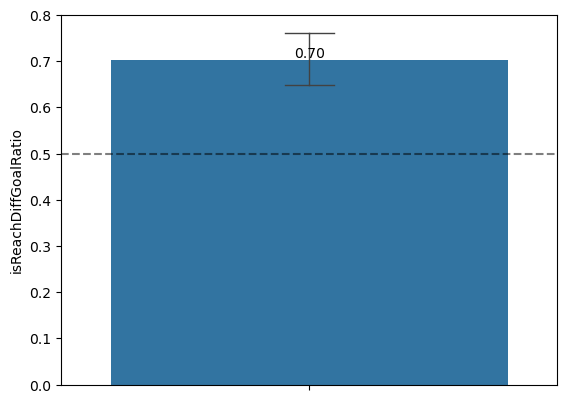

In [19]:
plotDF = pd.DataFrame()
plotDF['isReachDiffGoalRatio'] = dfTest.groupby(['name'], sort=False)["isReachDiffGoal"].mean()
plotDF = plotDF.reset_index()
print(researchpy.summarize(plotDF['isReachDiffGoalRatio']))

ax = sns.barplot(y="isReachDiffGoalRatio", data=plotDF, errwidth=1, capsize=.1, ci=95)
ax.bar_label(ax.containers[0], fmt='%.2f')
plt.axhline(y=0.5, color='k', linestyle='--', alpha=0.5)
plt.show()

/var/folders/wb/_15vsjnj26j9fsl6zcs0cphw0000gn/T/ipykernel_66981/1155275983.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  ax = sns.barplot(x='revealIntentionStagebyPosition', y="isReachDiffGoalRatio", data=plotDF, errwidth=1, capsize=.1, ci=95)
/var/folders/wb/_15vsjnj26j9fsl6zcs0cphw0000gn/T/ipykernel_66981/1155275983.py:5: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1}` instead.

  ax = sns.barplot(x='revealIntentionStagebyPosition', y="isReachDiffGoalRatio", data=plotDF, errwidth=1, capsize=.1, ci=95)


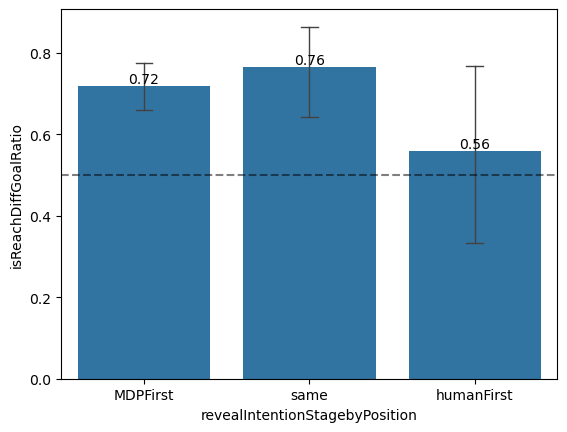

                               isReachDiffGoal          
isReachDiffGoal                          False True  All
revealIntentionStagebyPosition                          
MDPFirst                                   118  285  403
humanFirst                                  13   16   29
same                                        18   50   68
All                                        149  351  500


In [42]:
plotDF = pd.DataFrame()
plotDF['isReachDiffGoalRatio'] = dfTest.groupby(['name','revealIntentionStagebyPosition'], sort=False)["isReachDiffGoal"].mean()
plotDF = plotDF.reset_index()

ax = sns.barplot(x='revealIntentionStagebyPosition', y="isReachDiffGoalRatio", data=plotDF, errwidth=1, capsize=.1, ci=95)
ax.bar_label(ax.containers[0], fmt='%.2f')
plt.axhline(y=0.5, color='k', linestyle='--', alpha=0.5)
plt.show()

print(researchpy.crosstab(dfTest['revealIntentionStagebyPosition'],dfTest['isReachDiffGoal']))

## output data for R



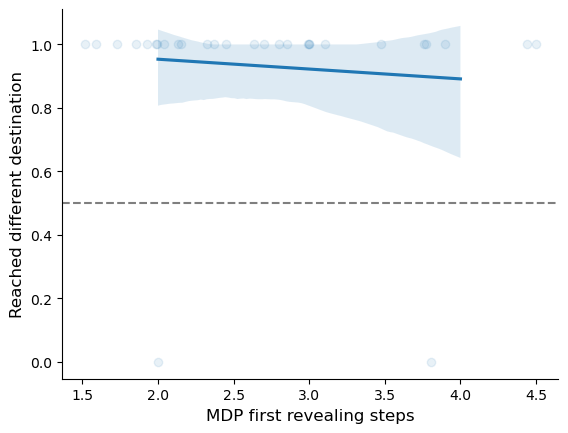

In [26]:
dfPlot = df[df.revealIntentionStagebyPosition == 'humanFirst']

ax = sns.regplot(x="firstRevealingStepMDP", y="commitmentHuman", x_jitter = 0.5,  scatter_kws = {"alpha": 0.1}, data=dfPlot, fit_reg=True)
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
plt.rcParams['svg.fonttype'] = 'none'

plt.xlabel('MDP first revealing steps', fontsize=12, color='black')
plt.ylabel('Reached different destination', fontsize=12, color='black')
plt.axhline(y=0.5, color='k', linestyle='--', alpha=0.5)

In [ ]:
os.environ['R_HOME'] = "/Library/Frameworks/R.framework/Resources"
from pymer4.models import lmer

dfLogit = df
model = lmer("isReachDiffGoal ~ firstRevealingStepMDP + (1|name)",
                data=dfLogit, family = 'binomial')
print(model.fit())
# dfLogit.to_csv('dfLogitExp2.csv', index=False)


R[write to console]: Error in library.dynam(lib, package, package.lib) : 
  shared object ‘methods.dylib’ not found



RRuntimeError: Error in library.dynam(lib, package, package.lib) : 
  shared object ‘methods.dylib’ not found


In [22]:
ax = sns.regplot(x="firstRevealingStepMDP", y="isReachDiffGoal", x_jitter = 0.5,  scatter_kws = {"alpha": 0.1}, data=model.data, fit_reg=True)
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
plt.rcParams['svg.fonttype'] = 'none'

plt.xlabel('MDP first revealing steps', fontsize=12, color='black')
plt.ylabel('Reached different destination', fontsize=12, color='black')
plt.axhline(y=0.5, color='k', linestyle='--', alpha=0.5)

NameError: name 'model' is not defined

### use ggplot like plot

/Users/chengshaozhe/Library/Python/3.10/lib/python/site-packages/rpy2/robjects/pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame
  warnings.warn('DataFrame contains duplicated elements in the index, '
/Users/chengshaozhe/Library/Python/3.10/lib/python/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "goals". Fall back to string conversion. The error is: <class 'list'>
  warnings.warn('Error while trying to convert '
/Users/chengshaozhe/Library/Python/3.10/lib/python/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: isReachDiffGoal~firstRevealingStepMDP+(1|name)

Family: binomial	 Inference: parametric

Number of observations: 450	 Groups: {'name': 50.0}

Log-likelihood: -265.068 	 AIC: 536.137

Random effects:

             Name    Var    Std
name  (Intercept)  0.651  0.807

No random effect correlations specified

Fixed effects:



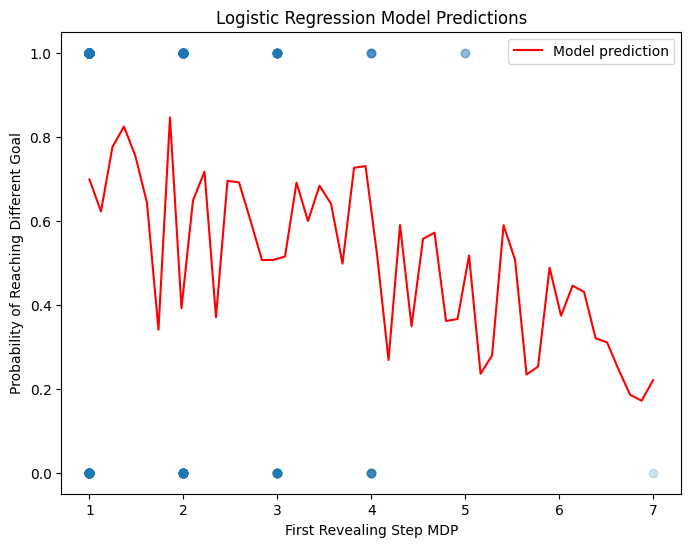

In [57]:
# Fit the model
model = Lmer('isReachDiffGoal ~ firstRevealingStepMDP + (1|name)', data=dfLogit, family='binomial')
model.fit()

# Plot model predictions
intercept = model.fixef['(Intercept)']
slope = model.fixef['firstRevealingStepMDP']

x = np.linspace(dfLogit['firstRevealingStepMDP'].min(), dfLogit['firstRevealingStepMDP'].max(), 50)
y = 1 / (1 + np.exp(-(intercept + slope * x)))

plt.figure(figsize=(8, 6))
plt.plot(x, y, 'r-', label='Model prediction')
plt.scatter(dfLogit['firstRevealingStepMDP'], dfLogit['isReachDiffGoal'], alpha=0.2)
plt.xlabel('First Revealing Step MDP')
plt.ylabel('Probability of Reaching Different Goal')
plt.title('Logistic Regression Model Predictions')
plt.legend()
plt.show()

In [29]:
import random
# Calculate distance to originally intended goal when AI reveals its intention
def calculate_distance_to_original_goal(row):
    if pd.isna(row['firstRevealingStepMDP']) or row['firstRevealingStepMDP'] < 0:
        return np.nan

    # Get the trajectory up to the AI revealing step
    trajectory = eval(row['trajectoryPlayer1'])

    # Position when AI reveals its intention
    pos_when_ai_reveals = trajectory[int(row['firstRevealingStepMDP'])]

    # Originally intended goal (human's initial goal)
    if row['firstRevealingStepHuman'] < row['firstRevealingStepMDP']:
        goalIndex = calFirstIntention(eval(row['goalPlayer1']))
        original_goal = row['goals'][goalIndex-1]
    else:
        original_goal = random.choice(row['goals'])

    # Calculate Manhattan distance - ensure both positions are numeric
    distance = calculateGridDis(pos_when_ai_reveals, original_goal)

    return distance

dfTest['disToGoalWhenAIRevealed'] = dfTest.apply(calculate_distance_to_original_goal, axis=1)


In [ ]:
model2 = Lmer("isReachDiffGoal ~ disToGoalWhenAIRevealed + (1|name)",
                data=dfLogit, family = 'binomial')
print(model2.fit())

ax = sns.regplot(x="disToGoalWhenAIRevealed", y="isReachDiffGoal", x_jitter = 0.5,  scatter_kws = {"alpha": 0.1}, data=model2.data, fit_reg=True, logistic=True)
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
plt.rcParams['svg.fonttype'] = 'none'

plt.xlabel('Distance to the originally intended goal\nwhen the AI reveals its intention', fontsize=12, color='black')
plt.ylabel('Reached different destination', fontsize=12, color='black')
plt.axhline(y=0.5, color='k', linestyle='--', alpha=0.5)

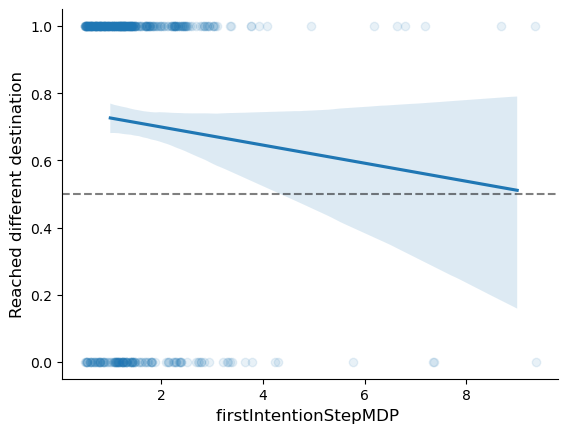

In [37]:
dfPlot = dfTest[dfTest.revealIntentionStagebyPosition != 'humanFirst']
# dfPlot.to_csv('Exp2HumanFirstIntentions.csv', index=False)

ax = sns.regplot(x="firstIntentionStepMDP", y="isReachDiffGoal", x_jitter = 0.5,  scatter_kws = {"alpha": 0.1}, data=dfPlot, fit_reg=True)
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
plt.rcParams['svg.fonttype'] = 'none'

plt.xlabel('firstIntentionStepMDP ', fontsize=12, color='black')
plt.ylabel('Reached different destination', fontsize=12, color='black')
plt.axhline(y=0.5, color='k', linestyle='--', alpha=0.5)

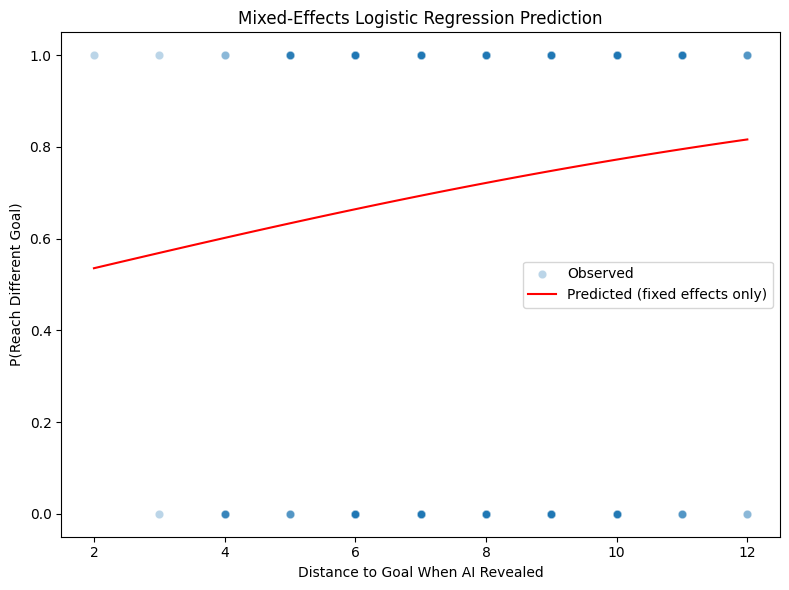

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Create new data over the predictor range
x_vals = np.linspace(dfLogit['disToGoalWhenAIRevealed'].min(),
                     dfLogit['disToGoalWhenAIRevealed'].max(), 100)
new_data = pd.DataFrame({
    'disToGoalWhenAIRevealed': x_vals,
    'name': 'placeholder_name'  # dummy level for random effect
})

# 2. Predict probabilities using the model (fixed effects only)
preds = model2.predict(new_data, verify_predictions=False)

# 3. Combine predictions
new_data['predicted_prob'] = preds

# 4. Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=dfLogit,
                x='disToGoalWhenAIRevealed',
                y='isReachDiffGoal',
                alpha=0.3, label='Observed')

plt.plot(new_data['disToGoalWhenAIRevealed'],
         new_data['predicted_prob'],
         color='red', label='Predicted (fixed effects only)')

plt.xlabel('Distance to Goal When AI Revealed')
plt.ylabel('P(Reach Different Goal)')
plt.title('Mixed-Effects Logistic Regression Prediction')
plt.legend()
plt.tight_layout()
plt.show()


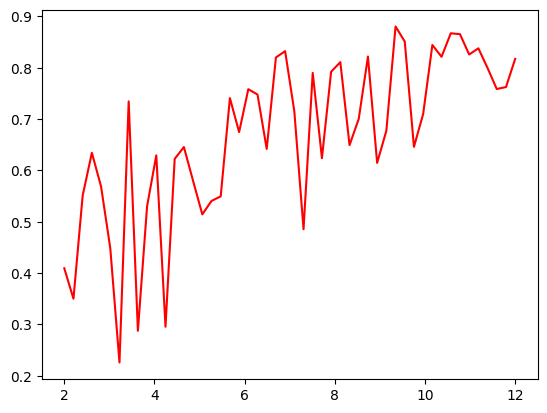

In [65]:
import numpy as np

# Pull the fixed effects
intercept = model2.fixef['(Intercept)']
slope = model2.fixef['disToGoalWhenAIRevealed']

# Create X range
x_vals = np.linspace(dfLogit["disToGoalWhenAIRevealed"].min(), dfLogit["disToGoalWhenAIRevealed"].max())
logit = intercept + slope * x_vals
pred_probs = 1 / (1 + np.exp(-logit))

plt.plot(x_vals, pred_probs, color='red')  # True logistic curve



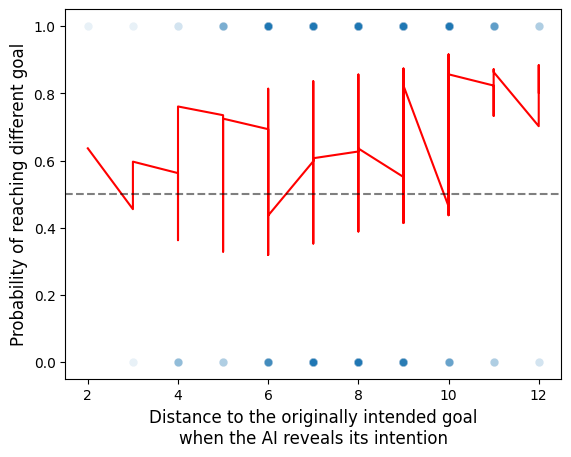

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sort for smooth curve plotting
df_sorted = dfLogit.sort_values("disToGoalWhenAIRevealed")

# Plot actual binary outcomes (jittered)
sns.scatterplot(x="disToGoalWhenAIRevealed", y="isReachDiffGoal", data=dfLogit, alpha=0.1)

# Plot predicted logistic curve
plt.plot(df_sorted["disToGoalWhenAIRevealed"], df_sorted["predicted"], color='red')

plt.xlabel('Distance to the originally intended goal\nwhen the AI reveals its intention', fontsize=12)
plt.ylabel('Probability of reaching different goal', fontsize=12)
plt.axhline(y=0.5, color='k', linestyle='--', alpha=0.5)
plt.show()


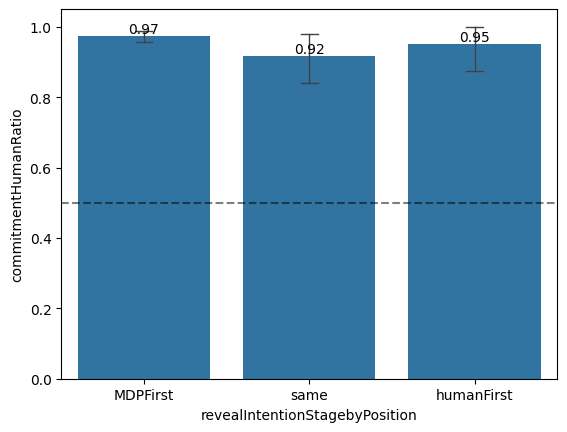

                               commitmentHuman          
commitmentHuman                              0    1  All
revealIntentionStagebyPosition                          
MDPFirst                                     9  347  356
humanFirst                                   2   27   29
same                                         6   59   65
All                                         17  433  450


In [123]:
plotDF = pd.DataFrame()
plotDF['commitmentHumanRatio'] = dfTest.groupby(['name','revealIntentionStagebyPosition'], sort=False)["commitmentHuman"].mean()
plotDF = plotDF.reset_index()

ax = sns.barplot(x='revealIntentionStagebyPosition', y="commitmentHumanRatio", data=plotDF, err_kws={'linewidth': 1}, capsize=.1, errorbar=('ci', 95))
ax.bar_label(ax.containers[0], fmt='%.2f')
plt.axhline(y=0.5, color='k', linestyle='--', alpha=0.5)
plt.show()

print(researchpy.crosstab(dfTest['revealIntentionStagebyPosition'],dfTest['commitmentHuman']))

In [144]:
# df = df[df.revealIntentionStage=="same"] # humanFirst,MDPFirst,same

dfTestMDPFirst = dfTest[dfTest.revealIntentionStagebyPosition == 'same']

# Use crosstab instead of summarize_cat which doesn't exist in researchpy
print(researchpy.crosstab(dfTestMDPFirst['isReachDiffGoal'], dfTestMDPFirst['isReachDiffGoal']))

import scipy
print(scipy.stats.binomtest(16, 29, 0.5, alternative='two-sided'))


                isReachDiffGoal         
isReachDiffGoal           False True All
isReachDiffGoal                         
False                        17    0  17
True                          0   48  48
All                          17   48  65
BinomTestResult(k=16, n=29, alternative='two-sided', statistic=0.5517241379310345, pvalue=0.711071103811264)


In [151]:
# df = df[df.revealIntentionStage=="same"] # humanFirst,MDPFirst,same

# dfTestSameTime = dfTest[ (dfTest.revealIntentionStage == 'humanFirst') | (dfTest.revealIntentionStage == 'MDPFirst')]

dfTestSameTime = dfTest[ (dfTest.revealIntentionStage == 'same')]

print(researchpy.crosstab(dfTestSameTime['isDiffFirstIntentionByPosition'], dfTestSameTime['commitmentHuman']))


#9/15 = 60% commitment if human and MDP reveal the same destination at the same time


                               commitmentHuman        
commitmentHuman                              0   1 All
isDiffFirstIntentionByPosition                        
False                                        6  13  19
True                                         0  21  21
All                                          6  34  40


In [ ]:
11,399, 410
6, 13, 19

In [156]:
import pandas as pd
import researchpy as rp

# Create the data in long format
data = {
    'group': ['Category1'] * (11 + 399) + ['Category2'] * (6 + 13),
    'outcome': ['Group1'] * 11 + ['Group2'] * 399 + ['Group1'] * 6 + ['Group2'] * 13
}

df = pd.DataFrame(data)

# Perform crosstab analysis
result = rp.crosstab(df['group'], df['outcome'], test='chi-square')

print("Contingency Table:")
print(result[0])
print("\nChi-square Test Results:")
print(result[1])

Contingency Table:
          outcome            
outcome    Group1 Group2  All
group                        
Category1      11    399  410
Category2       6     13   19
All            17    412  429

Chi-square Test Results:
                Chi-square test  results
0  Pearson Chi-square ( 1.0) =   39.8405
1                    p-value =    0.0000
2               Cramer's phi =    0.3047


/Users/chengshaozhe/Library/Python/3.10/lib/python/site-packages/researchpy/crosstab.py:146: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Pearson Chi-square ( 1.0) = ' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  table.iloc[0,0] = f"Pearson Chi-square ({dof: .1f}) = "


In [160]:
statDF = pd.DataFrame()
statDF['meanFirstRevealingStepMDP'] = dfTest.groupby(['name'], sort=False)["firstRevealingStepMDP"].mean()
statDF['meanFirstRevealingStepHuman'] = dfTest.groupby(['name'], sort=False)["firstRevealingStepHuman"].mean()
des2, res2 = researchpy.ttest(statDF['meanFirstRevealingStepMDP'], statDF['meanFirstRevealingStepHuman'])
print(des2)
print(res2)


                      Variable      N      Mean        SD        SE  \
0    meanFirstRevealingStepMDP   50.0  1.571111  0.298657  0.042237   
1  meanFirstRevealingStepHuman   50.0  5.413333  1.303336  0.184320   
2                     combined  100.0  3.492222  2.147757  0.214776   

   95% Conf.  Interval  
0   1.486234  1.655989  
1   5.042929  5.783737  
2   3.066061  3.918384  
                                  Independent t-test  results
0  Difference (meanFirstRevealingStepMDP - meanFi...  -3.8422
1                              Degrees of freedom =   98.0000
2                                               t =  -20.3188
3                           Two side test p value =    0.0000
4                          Difference < 0 p value =    0.0000
5                          Difference > 0 p value =    1.0000
6                                       Cohen's d =   -4.0638
7                                       Hedge's g =   -4.0326
8                                  Glass's delta1 =  -12.

/Users/chengshaozhe/Library/Python/3.10/lib/python/site-packages/researchpy/ttest.py:301: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'meanFirstRevealingStepMDP' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  table.iloc[0,0] = group1_name
/Users/chengshaozhe/Library/Python/3.10/lib/python/site-packages/researchpy/ttest.py:460: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Difference (meanFirstRevealingStepMDP - meanFirstRevealingStepHuman) = ' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  table2.iloc[0,0] = f"Difference ({group1_name} - {group2_name}) = "
